# Noise-Based Decision Test (FoM)
This notebook builds a **noise Figure of Merit (FoM)** from your backend adapter and then makes a **decision** (pass/fail)
based on thresholds that you can tune. It also plots the component fidelities with matplotlib.

**Idea:** If the device is “quiet enough” (good FoM), proceed with heavier experiments; otherwise, skip or reconfigure.


In [52]:
from qiskit import QuantumCircuit


# A helper function to create our phi_plus circuit.
def build_phi_plus_circuit() :
    phi_plus = QuantumCircuit(2)
    phi_plus.h(0)
    phi_plus.cx(0, 1)
    phi_plus.measure_all()
    return phi_plus

In [53]:

import json
import math
from typing import Any, Dict
import matplotlib.pyplot as plt

def on_pass(backend_adapter, figureOfMeritResults):
    print("\n--- Checks PASSED ---")
    props = figureOfMeritResults[0].get('properties', {})
    print("\n--- Calculated Properties ---")
    print(json.dumps(props, indent=2))
    print(f"\nNumber of Qubits: {getattr(backend_adapter, 'n_qubits', 'N/A')}")
    run_result = backend_adapter.run(build_phi_plus_circuit(), shots=2048)
    return run_result

def on_fail(backend_adapter, figureOfMeritResults):
    print("\n--- Checks FAILED ---")
    props = figureOfMeritResults[0].get('properties', {})
    print("\n--- Calculated Properties ---")
    print(json.dumps(props, indent=2))
    print(f"\nNumber of Qubits: {getattr(backend_adapter, 'n_qubits', 'N/A')}")
    return None


In [54]:
from qonscious.adapters import CustomNoisyBackendAdapter

adapter = CustomNoisyBackendAdapter(n_qubits=5)
print("Backend:", adapter.__class__.__name__)
print("n_qubits:", adapter.n_qubits)

# Optional: show a quick summary (pure prints, no logging)
adapter.print_noise_summary()


Backend: CustomNoisyBackendAdapter
n_qubits: 5
Custom Noisy Backend Adapter - Noise Summary
Number of qubits: 5

Depolarizing Errors:
  Single-qubit gates: 0.0010
  Two-qubit gates: 0.0100

Thermal Relaxation:
  Average T1: 50.00 µs
  Average T2: 70.00 µs
  Thermal population: 0.0100

Readout Errors:
  Readout error probability: 0.0200

Gate Times:
  Single-qubit gates: 50 ns
  Two-qubit gates: 300 ns


In [55]:
from qonscious.checks import MeritComplianceCheck
from qonscious.foms import BackendNoiseFoM

MIN_OVERALL_NOISE = 0.985
MIN_TWO_QUBIT_FIDELITY = 0.985
MIN_READOUT_FIDELITY = 0.970

def requires_noise_quality():
    """Return a predicate that validates the backend against the configured thresholds."""
    def predicate(result):
        props = result["properties"]
        return (
            props["overall_noise_score"] >= MIN_OVERALL_NOISE
            and props["two_qubit_gate_fidelity"] >= MIN_TWO_QUBIT_FIDELITY
            and props["readout_fidelity"] >= MIN_READOUT_FIDELITY
        )
    return predicate
check = MeritComplianceCheck(
    figure_of_merit=BackendNoiseFoM(),
    decision_function=requires_noise_quality()
)

In [56]:
from qonscious.actions import QonsciousCallable
from qonscious import run_conditionally

qonscious_result = run_conditionally(
    backend_adapter=adapter,
    checks=[check],
    on_pass=QonsciousCallable(on_pass),
    on_fail=QonsciousCallable(on_fail),
)


--- Checks PASSED ---

--- Calculated Properties ---
{
  "backend_qubits": 5,
  "backend_name": "CustomNoisyBackendAdapter",
  "T1": 5e-05,
  "T2": 7e-05,
  "overall_noise_score": 0.991597512615847,
  "single_qubit_gate_fidelity": 0.999,
  "two_qubit_gate_fidelity": 0.99,
  "readout_fidelity": 0.98,
  "coherence_factor": 0.9975047128046468,
  "single_qubit_gate_duration_seconds": 5.0000000000000004e-08,
  "two_qubit_gate_duration_seconds": 3.0000000000000004e-07,
  "thermal_population_fraction": 0.01
}

Number of Qubits: 5


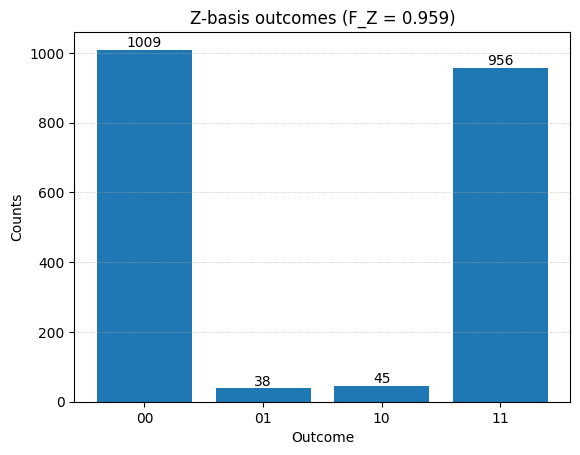

In [57]:
import matplotlib.pyplot as plt

# Get the counts of each possibly observed result 00, 01, 10, 11
counts = qonscious_result['experiment_result']['counts'] # type: ignore

# Choose a fixed label order for 2-qubit outcomes
labels = ['00', '01', '10', '11']
values = [counts.get(k, 0) for k in labels]

N = sum(values)
F_Z = (counts.get('00', 0) + counts.get('11', 0)) / N if N else float('nan')
title = f"Z-basis outcomes (F_Z = {F_Z:.3f})"

fig, ax = plt.subplots()
bars = ax.bar(labels, values)
ax.set_title(title)
ax.set_xlabel("Outcome")
ax.set_ylabel("Counts")
ax.set_ylim(bottom=0)
ax.grid(True, axis='y', linestyle=':', linewidth=0.5)

# Add labels on top of each bar
for bar, value in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        str(value),
        ha='center', va='bottom'
    )
plt.show()
